# DSCI 573: Feature and Model Selection 

## Lecture 8: More about Logistic Regression

UBC Master of Data Science program, 2020-21

Instructor: Varada Kolhatkar 

In [1]:
import os

%matplotlib inline
import string
from collections import deque

import matplotlib.pyplot as plt
import numpy as np
import numpy.random as npr
import pandas as pd

# other
from sklearn.metrics import accuracy_score, log_loss, make_scorer, mean_squared_error
from sklearn.model_selection import (
    cross_val_score,
    cross_validate,
    train_test_split,
)

from sklearn import datasets
from sklearn.linear_model import LogisticRegression

pd.set_option("display.max_colwidth", 200)
# pip install git+git://github.com/mgelbart/plot-classifier.git
from plot_classifier import plot_classifier, plot_loss_diagram


### Learning outcomes 

From this lecture, students are expected to be able to: 

- Explain the "column of ones" trick. 
- Explain vectorization in logistic regression.  
- Explain the intuition behind logistic loss. 
- Explain the difference between sigmoid and logistic loss. 
- Implement logistic loss. 
- Use `sklearn`'s `log_loss` function. 
- Explain the difference between loss and error. 
- Explain and implement softmax function.
- Use `multi_class="multinomial"` for `LogisticRegression` for multi-class classification. 

## 1. Logistic regression: `predict`
- Video 1

- It is a classification algorithm. Since it's linear and a classifier, we call it a linear classifier.

- Recall that logistic regression learns the weights $w$ and bias or intercept $b$
- There's one coefficient per feature, plus an intercept, just like linear regression.
- We combine our features and coefficients with a dot product: 

\begin{equation}
\begin{split}
z =& w_1x_1 + \dots w_dx_d + b\\
=& w^Tx + b
\end{split}
\end{equation}


In [2]:
d = 5
x = np.random.uniform(-1, 1, d)
w = np.random.uniform(-1, 1, d) 
print('x:', x)
print('w:', w)

x: [ 0.77822721  0.43548783 -0.70491797  0.0413766  -0.84906356]
w: [ 0.70065258  0.66882859  0.59905631  0.51125365 -0.87355653]


In [3]:
print('w^T.x: ', np.dot(w.T, x))

w^T.x:  1.1771070085710456


### "column of ones" trick 
 
- We'll often ignore the intercept $b$ because of the "column of ones" trick. 
- For simplicity, we rename bias term as $w_0$ and introduce a dummy feature $x_0$ whose value is always 1. 
- So $w_1x_1 + \dots + w_nx_n + b$ becomes $w_0x_0 + w_1x_1 + \dots + w_nx_n$, where $x_0$ is always 1. 

### "column of ones" trick: example

- Suppose $X$ has only one feature, say $x_1$: 
$$X = \begin{bmatrix}0.86 \\ 0.02 \\ -0.42 \end{bmatrix}$$ 
- Make a new matrix $Z$ with an extra feature (say $x_0$) whose value is always 1. 
$$Z = \begin{bmatrix}1 & 0.86\\ 1 & 0.02 \\ 1 & -0.42\\ \end{bmatrix}$$
- Use $Z$ instead of $X$. 

In [4]:
n, d = 100, 5
X = np.random.uniform(-1, 1, [n,d])
X[:4]

array([[ 0.5060273 ,  0.42174358, -0.43451624, -0.3821009 , -0.96547577],
       [-0.19443369,  0.94406096, -0.6897764 , -0.22245692,  0.63942998],
       [ 0.56814134,  0.75783539, -0.55455206,  0.17784076, -0.34708951],
       [ 0.4983871 ,  0.41544464,  0.12728545, -0.5230312 , -0.00424926]])

Let's add a column of ones to create `Z`.

In [5]:
Z = np.ones((n,d+1))
Z[:,1:] = X
Z[:4]

array([[ 1.        ,  0.5060273 ,  0.42174358, -0.43451624, -0.3821009 ,
        -0.96547577],
       [ 1.        , -0.19443369,  0.94406096, -0.6897764 , -0.22245692,
         0.63942998],
       [ 1.        ,  0.56814134,  0.75783539, -0.55455206,  0.17784076,
        -0.34708951],
       [ 1.        ,  0.4983871 ,  0.41544464,  0.12728545, -0.5230312 ,
        -0.00424926]])

- Suppose $w$ are our learned parameters. 

In [6]:
w = np.random.uniform(-1, 1, d+1) 
w

array([ 0.52480423, -0.41598735,  0.06382638, -0.79729799,  0.8001295 ,
        0.01362316])

### Vectorization

- We can organize all the training examples into a matrix $Z$ with one row per training example. 
- Then compute the predictions for the whole dataset succinctly as $Zw$ for the whole dataset: 
- We take each row of $Z$ and dot-product it with $w$. So the result is a vector of all our predictions.

$$Zw = \begin{bmatrix}w^Tz_0 \\ w^Tz_1 \\ \vdots \\ w^Tz_n\end{bmatrix} = \begin{bmatrix}z_0w \\ z_1w \\ \vdots \\ z_nw\end{bmatrix} = \begin{bmatrix} \hat{y_1} \\ \hat{y_2} \\ \vdots \\ \hat{y_n}\end{bmatrix} $$



In [7]:
y_hat = Z@w
y_hat[:10]

array([ 0.36877753,  1.04661623,  0.91654494, -0.17603719,  1.42893646,
        0.51584516,  1.05058312,  0.82968848,  1.30954244,  0.40445746])

In [8]:
y_hat = np.dot(Z, w)
y_hat[:10]

array([ 0.36877753,  1.04661623,  0.91654494, -0.17603719,  1.42893646,
        0.51584516,  1.05058312,  0.82968848,  1.30954244,  0.40445746])

### Scores to probabilities 

- The numbers we saw above are "raw model output".
- For linear regression this would have been the prediction.
- For logistic regression, you check the **sign** of this value.
  - If positive, predict $+1$; if negative, predict $-1$.
  - These are "hard predictions".
- You can also have "soft predictions", aka predicted probabilities. 
  - To convert the raw model output into probabilities, instead of taking the sign, we apply the sigmoid.

### The sigmoid function 
- The sigmoid function "squashes" the raw model output from any number to the range $[0,1]$.
$$\frac{1}{1+e^{-x}}$$ 
- Then we can interpret the output as probabilities.

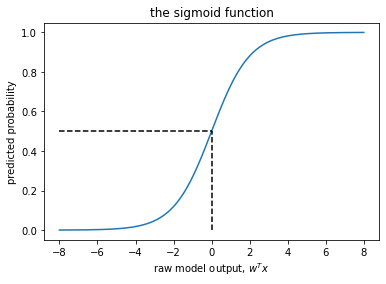

In [9]:
sigmoid = lambda x: 1/(1+np.exp(-x))
raw_model_output = np.linspace(-8,8,1000)
plt.plot(raw_model_output, sigmoid(raw_model_output));
plt.plot([0,0],[0,0.5], '--k')
plt.plot([-8,0],[0.5,0.5], '--k')
plt.xlabel("raw model output, $w^Tx$"); plt.ylabel("predicted probability");plt.title("the sigmoid function");

In [10]:
y_hat[:10]

array([ 0.36877753,  1.04661623,  0.91654494, -0.17603719,  1.42893646,
        0.51584516,  1.05058312,  0.82968848,  1.30954244,  0.40445746])

In [11]:
sigmoid(y_hat)[:10]

array([0.59116355, 0.74012459, 0.71433759, 0.456104  , 0.80673555,
       0.62617571, 0.74088686, 0.69628906, 0.78743658, 0.59975814])

### Example

In [12]:
cities_df = pd.read_csv("data/canada_usa_cities.csv")
train_df, test_df = train_test_split(cities_df, test_size=0.2, random_state=123)
#mapping = {'Canada': 1, 'USA': 0}
#train_df.replace({'country': mapping}, inplace=True)
#test_df.replace({'country': mapping}, inplace=True)
X_train, y_train = train_df.drop(columns=["country"], axis=1), train_df["country"]
X_test, y_test = test_df.drop(columns=["country"], axis=1), test_df["country"]
y_train_bin = np.where(y_train == 'Canada', 1, 0)

In [13]:
X_train.columns

Index(['longitude', 'latitude'], dtype='object')

In [14]:
lr = LogisticRegression(fit_intercept=False)
lr.fit(X_train, y_train_bin)
print("Model weights: %s"%(lr.coef_)) # these are weights
print("Model intercept: %s"%(lr.intercept_)) # this is the bias term
data = {'features': X_train.columns, 'coefficients':lr.coef_[0]}
pd.DataFrame(data)

Model weights: [[0.04740261 0.10963683]]
Model intercept: [0.]


,features,coefficients
0,longitude,0.047403
1,latitude,0.109637


### Decision boundary of logistic regression

- The decision boundary is a hyperplane dividing the feature space in half. 
- The decision boundary is a $d-1$-dimensional hyperplane, where $d$ is the number of features.
- You can think of the coefficients as controlling the orientation of the boundary.

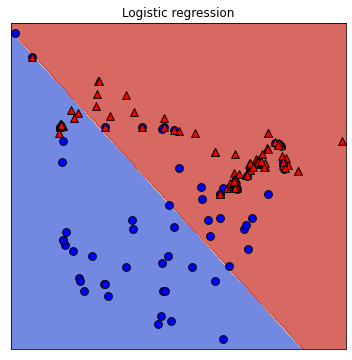

In [15]:
plt.figure(figsize=(6, 6))
plot_classifier(X_train, y_train_bin, lr, ax=plt.gca())
plt.title("Logistic regression");

### Prediction with learned weights

In [16]:
example = X_test.iloc[0,:]
example.tolist()

[-64.8001, 46.098]

In [17]:
np.dot(example.tolist(), lr.coef_.flatten())

1.982344648567123

In [18]:
lr.classes_

array([0, 1])

- Our threshold here is 0
- The sign is positive and so predict class 1 (Canada in our case). 

In [19]:
lr.predict([example])

array([1])

### Predicting probabilities 

- We can get the probability scores (confidence) of the classifier's prediction using the `model.predict_proba` method. 

In [20]:
lr.predict_proba([example])

array([[0.12106912, 0.87893088]])

Let's examine whether we get the same answer if we call sigmoid on $w^Tx$ or $x.w$

In [21]:
np.dot(example.tolist(), lr.coef_.flatten())

1.982344648567123

In [22]:
sigmoid(np.dot(example.tolist(), lr.coef_.flatten()))

0.8789308811659498

We get the same probability score!!

- Generally we use regularization with logistic regression. 
- By default, `sklearn`'s logistic regression uses `l2` penalty with `C=1.0`, where `C` is inverse of regularization strength; smaller values specify stronger regularization.

> class sklearn.linear_model.LogisticRegression(penalty='l2', *, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)


- More than any other topic I've seen, logistic regression spans both statistics and ML.
- In DSCI 562, you'll learn about logistic regression as a GLM, with the link function, maximum likelihood, etc.
- That formulation is equivalent, but we'll do things differently:
  - In ML, we encode $y$ as $+1$ and $-1$, as opposed to $1$ and $0$. This makes our math a bit cleaner.
  - We'll also think more from an optimization perspective rather than a likelihood / distributional assumptions perspective. 

## Logistic regression: `fit`
- Video 2 

### Goal

- Learn parameters $w$ and $b$ which make predictions for each training example as close as possible to the true $y$. 
- We need two things: 
    - **Loss function**: A metric to measure how much a prediction differs from the true $y$. 
    - **Optimization algorithm**: for iteratively updating the weights so as to minimize the loss function. (More on this in 572.)   
- Assumption: We are going to assume that your classes are -1 and +1. 

Note: You'll learn the maximum likelihood interpretation of the loss in DSCI 562. Here we take a different perspective. 

### Least squares loss function

- We are familiar with least squares loss function used in linear regression. 

$$f(w)=\sum_{i=1}^n (w^Tx_i-y_i)^2$$

- It's a function of $w$.
- We define loss of a single example as squared difference between prediction and true target.
- The total loss is summation of losses over all training examples.  

### Least squares for logistic regression? 

$$f(w)=\sum_{i=1}^n (w^Tx_i-y_i)^2$$

- For logistic regression $y_i$ values are just +1 or -1. 
- The raw model output $w^Tx_i$ can be any number. 
- Does it make sense to use this loss function for logistic regression?
    - Not really. 

### Why not least squares loss for logistic regression?

$$f(w)=\sum_{i=1}^n (w^Tx_i-y_i)^2$$

- Example: 
    - Suppose $w^Tx_i$ (prediction) is 101 and $y_i$ is $+1$. 
    - The model is behaving correctly, because $101$ is positive and so it will predict $+1$.
    - But according to this loss function, you have a bad prediction because the loss is huge: $(101 - 1)^2 = 10000$. 
- The squared error doesn't make sense here.    
    - It does not make sense to compare raw model outputs which can be any number to 1 or -1. 

### Want

- Need a loss that encourages 
    - $w^Tx_i$ to be positive when $y_i$ is $+1$ 
    - $w^Tx_i$ to be negative when $y_i$ is $-1$

### Key idea 

- **Multiply $y_iw^Tx_i$**. 
- We always want this quantity to be positive because
- If $y_i$ and $w^Tx_i$ have the _same sign_, the product will be positive.
    - $w^Tx_i$ is positive and $y_i$ is positive 🙂
    - $w^Tx_i$ is negative and $y_i$ is negative 🙂
- If they have _oppositve signs_, the product will be negative.
    - $w^Tx_i$ is positive and $y_i$ is negative 😔 
    - $w^Tx_i$ is negative and $y_i$ is positive 😔

- So, we want a loss that's sort of like 
$$f(w) = -\sum_{i=1}^n y_iw^Tx_i$$ 
- The negative sign above is because we want to minimize.
    - Maximizing the actual amount and minimizing the negative amount are the same thing. 
- By making this small, we encourage the model to make correct predictions.  
- The above loss does not quite work out. (I believe it has no minimum in most cases.) 

### Logistic loss 

- So we do something similar instead:
  
  $$f(w)=\sum_{i=1}^n\log\left(1+\exp(-y_iw^Tx_i)\right)$$

- Let's plot this function. 

### Logistic loss: intuition 

- The function gets smaller as $y_iw^Tx_i$ gets larger, so it encourages correct classification. 
- So if we minimize this loss, which means if we move down and to the right, it is encouraging positive values and hence correct predictions. 
- Not perfect but reasonable! 

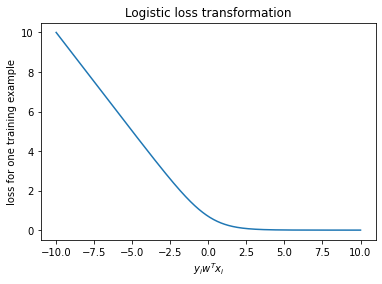

In [23]:
grid = np.linspace(-10,10,1000)
fun = lambda z: np.log(1+np.exp(-z))
plt.plot(grid, fun(grid));
plt.xlabel("$y_iw^Tx_i$");
plt.ylabel("loss for one training example")
plt.title("Logistic loss transformation");

### Sigmoid vs. logistic loss

- A common source of confusion: 
    - Sigmoid: $$\frac{1}{(1+\exp(-z))}$$
    - logistic loss: $$\log(1+\exp(-z))$$
- They look very similar and both are used in logistic regression.
- They have very different purposes. 

### Sigmoid vs. logistic loss

- Sigmoid function: $$\frac{1}{(1+\exp(-z))}$$
    - Maps $w^Tx_i$ to a number in $[0,1]$, to be interpreted as a probability. 
    - This is important in `predict_proba`. 

- Logistic loss: $\log(1+\exp(-z))$ 
    - Maps $y_iw^Tx_i$ to a positive number, which is the loss contribution from one training example. 
    - This is important in `fit`.

### Hinge loss (optional)

- Another loss for linear classifiers is **Hinge loss**, which is: 

$$max\{0,1-y_iw^Tx_i\}$$ 

- When you use Hinge loss with L2 regularization, it's called a linear support vector machine.  
    $$f(w) = \sum_{i=1}^n max\{0,1-y_iw^Tx_i\} + \frac{\lambda}{2} \lVert w\rVert_2^2$$
- For more mathematical details on these topics see the following slide decks from CPSC 340. 
    - [Linear classifiers](https://www.cs.ubc.ca/~schmidtm/Courses/340-F19/L20.pdf)
    - [More on linear classifiers](https://www.cs.ubc.ca/~schmidtm/Courses/340-F19/L19.pdf)
- It will make more sense when you learn about optimization.     

## Let's implement logistic loss function  

- Video 3

Let's code up logistic loss in Python. 

$$f(w)=\sum_{i=1}^n\log\left(1+\exp(-y_iw^Tx_i)\right)$$    

In [24]:
def my_log_loss(w, X, y):
    return np.sum(np.log(1 + np.exp(-y*(X@w))))

Recall that this loss function works when our classes are -1 and 1. 

In [25]:
cities_df = pd.read_csv("data/canada_usa_cities.csv")
train_df, test_df = train_test_split(cities_df, test_size=0.2, random_state=123)
X_train, y_train = train_df.drop(columns=["country"], axis=1), train_df["country"]
X_test, y_test = test_df.drop(columns=["country"], axis=1), test_df["country"]

y_train_neg_1 = np.where(y_train == 'Canada', -1, 1) 

For simplicity we are ignoring the intercept. 

In [26]:
lr = LogisticRegression(fit_intercept=False)
lr.fit(X_train, y_train_neg_1);

In [27]:
my_log_loss(np.squeeze(lr.coef_), X_train, y_train_neg_1)

92.8431566075896

You can use `sklearn`'s `log_loss` function to get logistic loss. 

In [28]:
from sklearn.metrics import log_loss

probs = lr.predict_proba(X_train)
log_loss(y_train_neg_1, probs, normalize=False)

92.84315660758959

In 572, you'll see how after each iteration of your optimization algorithm your loss changes. 

### Another source of confusion 

- You might see this alternative formulation for logistic loss. 
- For example see [here](https://developers.google.com/machine-learning/crash-course/logistic-regression/model-training) or [here](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html).


$$f(w) = \sum_{x,y \in D} -y log(\hat{y}) - (1-y)log(1-\hat{y})$$

- Although this looks very different than the loss function we saw before, they produce the same loss. 
- This is also referred to as cross-entropy loss. 
- Logistic loss = cross-entropy loss 

### The key difference between them

- This formulation assumes the classes to be 0 and 1. 
$$f(w) = \sum_{x,y \in D} -y log(\hat{y}) - (1-y)log(1-\hat{y})$$
   
- Our previous formulation assumes classes to be -1 and +1. 
  $$f(w)=\sum_{i=1}^n\log\left(1+\exp(-y_iw^Tx_i)\right)$$    

Let's examine this. The following code 

- Replaces Canada with -1 and USA with 1 to create `y_train_neg_1`.
- Replaces Canada with 0 and USA with 1 to create `y_train_0`.

In [29]:
y_train_neg_1 = np.where(y_train == 'Canada', -1, 1) 
y_train_0 = np.where(y_train == 'Canada', 0, 1) 

### Let's define our loss functions

In [30]:
def my_log_loss(w, X, y): # this formulation assumes classes to be -1 and 1
    return np.sum(np.log(1 + np.exp(-y*(X@w))))

In [31]:
def my_cross_ent_loss(y, probs): # this formulation assumes classes to be 0 and 1
    return np.sum(-y*np.log(probs[:,1])-(1-y)*np.log(probs[:,0]))

In [32]:
lr = LogisticRegression(fit_intercept=False)
lr.fit(X_train, y_train_neg_1);

In [33]:
probs = lr.predict_proba(X_train)

Let's check the loss with `sklearn`'s `log_loss` in both cases. 

In [34]:
log_loss(y_train_0, probs, normalize=False)

92.84315660758959

In [35]:
log_loss(y_train_neg_1, probs, normalize=False)

92.84315660758959

Let's check log loss with `y_train_neg_1`. 

In [36]:
my_log_loss(np.squeeze(lr.coef_), X_train, y_train_neg_1)

92.8431566075896

Let's check cross entropy loss with `y_train_0`. 

In [37]:
my_cross_ent_loss(y_train_0, probs)

92.84315660758959

We get the same result in all cases!! 

### Error vs. loss

- With earlier methods like random forests, we just talked about accuracy (or error rate, which is 1 minus accuracy).
- With logistic regression, there are two separate metrics we need to keep in mind.
- scikit-learn's `score` returns the accuracy. 

In [38]:
lr = LogisticRegression(fit_intercept=False)
lr.fit(X_train, y_train_neg_1);
lr.score(X_train, y_train_neg_1)

0.6946107784431138

- So we got this accuracy, and the error is 1 minus this. 
- But the loss is different.

In [39]:
my_log_loss(np.squeeze(lr.coef_), X_train, y_train_neg_1)

92.8431566075896

- So, why not use the error rate as the loss, and directly maximize accuracy?
- Because it's not a smooth function, which makes it hard to optimize.
- This is a bit beyond the scope of the course.

## Softmax

- Video 4

### Softmax function

Standard way to convert numbers in a vector into a probability distribution.  

Intuition: 
- Exponentiate to put things in positive land. 
- Normalize to give probability distribution. 

Let's create a vector with random numbers. 

In [40]:
d = 10
vec = np.random.uniform(-4, 2, d)
vec

array([ 0.08702828, -0.22180959,  1.41595878, -1.7871291 , -3.96587657,
        1.46869959, -2.95684709,  1.12029123, -3.61956621, -1.3392124 ])

Exponentiate to put things in positive land.

In [41]:
vec_exp = np.exp(vec)
vec_exp

array([1.09092753, 0.80106788, 4.12043514, 0.16744018, 0.01895142,
       4.34358303, 0.05198256, 3.06574692, 0.0267943 , 0.26205198])

- Normalizing gives us a probability distribution. 

In [42]:
vec_exp

array([1.09092753, 0.80106788, 4.12043514, 0.16744018, 0.01895142,
       4.34358303, 0.05198256, 3.06574692, 0.0267943 , 0.26205198])

In [43]:
vec_softmax = vec_exp/np.sum(vec_exp)
vec_softmax

array([0.0782084 , 0.05742842, 0.29539327, 0.01200376, 0.00135862,
       0.31139071, 0.00372662, 0.21978286, 0.00192088, 0.01878646])

In [44]:
np.sum(vec_softmax)

1.0000000000000002

- They sum to 1.0! 

Let's write a function for softmax. 

In [45]:
my_softmax = lambda z: np.exp(z)/np.sum(np.exp(z))

In [46]:
my_softmax(vec)

array([0.0782084 , 0.05742842, 0.29539327, 0.01200376, 0.00135862,
       0.31139071, 0.00372662, 0.21978286, 0.00192088, 0.01878646])

In [47]:
np.sum(my_softmax(vec))

1.0000000000000002

### `LogisticRegression` with `multi_class="multinomial"`

- In 571, we carried out multi-class classification with logistic regression using meta strategies such as one-vs-rest and one-vs-one. 
- You can also do multi-class classification using a different loss function called softmax loss, aka the categorical cross-entropy loss for logistic regression with multi-class. 

### `LogisticRegression` with `multi_class="multinomial"`
- Intuition    
    - The loss tries to make the probability of the correct class large.
    - Which forces the rest to be small since they must add to 1.
    - It's a generalization of the logistic loss to multi-class.
- Note that softmax function and softmax loss although same in spirit are different things and have different purposes.    

- Let's carry out multi-class classification with logistic regression with softmax loss or categorical cross-entropy loss. 
- Let's try it on the digits data set, which contains images of hand-written digits: 10 classes where each class refers to a digit.

In [48]:
digits = datasets.load_digits()

<Figure size 432x288 with 0 Axes>

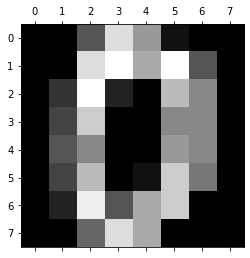

In [49]:
plt.gray() 
plt.matshow(digits.images[0]) 
plt.show() 

In [50]:
X = digits['data']
y = digits['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [51]:
lr_multi = LogisticRegression(multi_class="multinomial", max_iter = 2000)
lr_multi.fit(X_train, y_train);

In [52]:
print("Predicted:", lr_multi.predict(X_test)[0])
print("Actual:", y_test[0])

Predicted: 6
Actual: 6


In [53]:
lr_multi.predict_proba(X_test)[0]

array([6.25220632e-08, 3.97982950e-11, 1.40280689e-13, 1.40386857e-13,
       1.27294274e-09, 2.22986984e-11, 9.99987983e-01, 3.83782018e-11,
       1.19531779e-05, 1.33030006e-11])

This is the output of softmax. Here is an excerpt from sklearn documentation. 
> For a multi_class problem, if multi_class is set to be “multinomial” the softmax function is used to find the predicted probability of each class. Else use a one-vs-rest approach, i.e calculate the probability of each class assuming it to be positive using the logistic function. and normalize these values across all the classes.

In [54]:
np.argmax(lr_multi.predict_proba(X_test)[0])

6

- It's actually the "soft max" because it's like the max function but "soft".

## Summary and final remarks

- Video 5

## Summary of the course 

- In this course we learned about 
    - Evaluation metrics for classification
    - Class imbalance
    - Evaluation metrics for regression
    - Feature engineering, polynimial basis, radial basis functions 
    - Feature importances for linear classifiers
    - Feature selection with RFE, forward selection, L0 penalty 
    - Ensemble methods 
    - Feature importances and interpretation for non-linear models
    - Loss functions
    - L2 and L1 regularization
    - Logistic loss, softmax 

## Map of ML courses in MDS 

<img src="imgs/MDS-ML-map.png" height="1500" width="1500"> 

### Coming up ...

- Optimization, deep learning, PyTorch, convolution neural networks  (572)
    - You will be implementing logistic regression on your own in 572!!! 
- Clustering, expectation maximization, PCA, recommendation systems (563)
- Word embeddings, Markov models, topic modeling, recurrent neural networks, long-short term memory networks, image captioning (575)

### Final remarks

I enjoyed teaching you this course! Thank you for your support, your engagement, great questions, and your feedback!
I hope you now feel comfortable with building a supervised machine learning pipeline for a given prediction problem. 

Enjoy your break and I look forward to teach you again next year :)! 

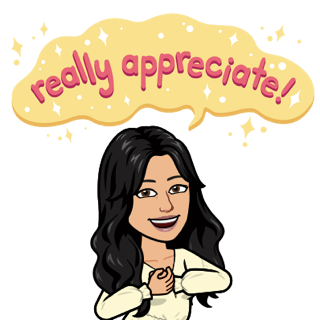

FYI: The online course evaluations are up, it'll be great if you can fill them in when you get a chance. 

### True/False questions for class discussion (Videos 1 and 2)

1. When the term $y_iw^Tx_i$ in logistic loss is positive, it means we have a correct prediction. (True)
2. Minimizing logistic loss leads to mapping $y_iw^Tx_i$ to a positive number. (True)
3. Using least squares loss for logistic regression makes sense because logistic regression is very similar to linear regression except that it's used for classification. (False)
4. Logistic loss formulation we looked at expects the target values to be -1 and +1. (True) 
5. Sigmoid and logistic loss are basically the same thing with different names. (False)

### True/False questions for class discussion (Videos 3 and 4)
1. Loss is basically the same as error (1 - accuracy) on the training set. (False)
2. When you apply the softmax function you may end up messing up the scale of the numbers in your vector. (True according to me. But kind of ambiguous.)
3. You can use logistic regression with softmax or multinomial cross-entropy loss for multi-class classification problems. (True)  
4. If you are using L2 penalty with logistic loss and if you increase the regularization strength you would expect the loss to go down. (False) 
5. If you are using L2 penalty with logistic loss and if you increase the regularization strength you would expect a lower training score but potentially higher CV score if it helped with overfitting. (True)
